### Brain MRI segmentation with Unet 

The data were taken from https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

#### Import the libraries

In [1]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

### Import the data 

In [2]:
DataPath = "lgg-mri-segmentation/kaggle_3m/"

dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))
            
            
imagePath_df = pd.DataFrame({'directory':dirs, 'images': images, 'masks': masks})

In [3]:
imagePath_df.head()

,directory,images,masks
0,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_10.tif,TCGA_CS_4941_19960909_10_mask.tif
1,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_11.tif,TCGA_CS_4941_19960909_11_mask.tif
2,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_12.tif,TCGA_CS_4941_19960909_12_mask.tif
3,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_13.tif,TCGA_CS_4941_19960909_13_mask.tif
4,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_14.tif,TCGA_CS_4941_19960909_14_mask.tif


In [4]:
imagePath_df.shape

(3929, 3)

In [5]:
# Check the size of the image 

def print_imShape():
    idx = np.random.randint(0, len(imagePath_df))
    
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    print(image.shape, mask.shape)
    
    
for i in range(3):
    print_imShape()    
    

(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)


### Visualize the data 

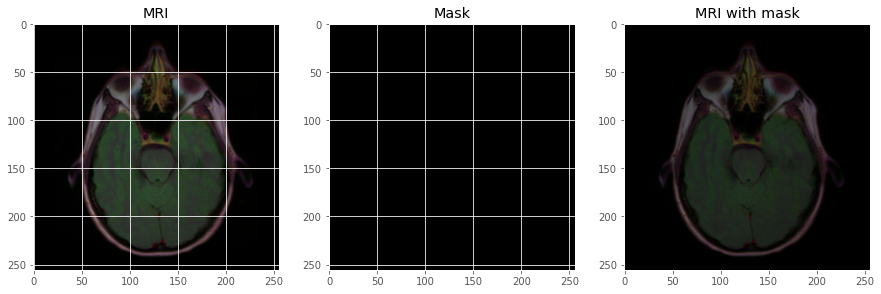

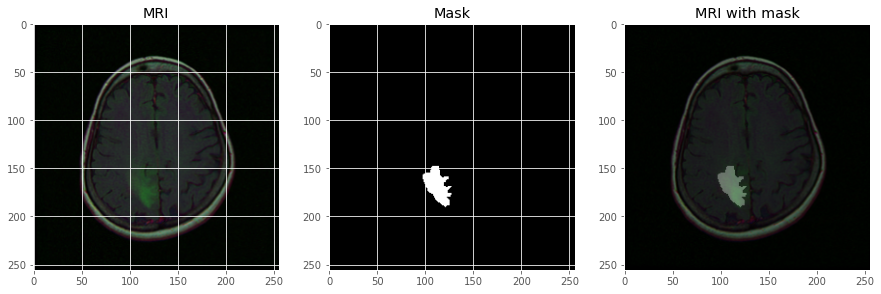

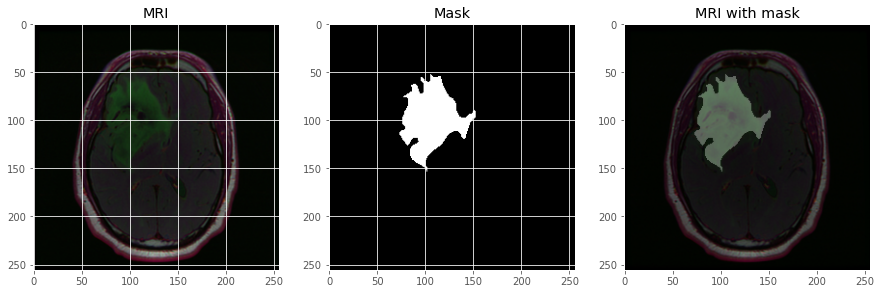

In [6]:
def plot_images():
    idx = np.random.randint(0, len(imagePath_df))
    
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    fig, axs = plt.subplots(1,3, figsize=[15,15])
    
    axs[0].imshow(image)
    axs[0].set_title('MRI')
    
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.3)
    axs[2].set_title('MRI with mask')
    
    plt.grid(False)
    plt.show()
    
    
for i in range(3):
    plot_images()

In [7]:
imagePath_df['image-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['images']
imagePath_df['mask-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['masks'] 

In [8]:
# Finaldataframe with image and mask directories 
imagePath_df.head(2)


,directory,images,masks,image-path,mask-path
0,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_10.tif,TCGA_CS_4941_19960909_10_mask.tif,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...
1,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_11.tif,TCGA_CS_4941_19960909_11_mask.tif,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...


### Data Generator 

##### Train Data 

In [9]:
train1 , test = train_test_split(imagePath_df, test_size=0.10)

train , val = train_test_split(train1, test_size=0.10)




EPOCHS = 100
BATCH_SIZE = 32
ImgHeight = 256
ImgWidth = 256
Channels = 3


# Data Augmentation 

data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')




# image and mask generator
imagegen = ImageDataGenerator(rescale=1./255., **data_augmentation)
maskgen = ImageDataGenerator(rescale=1./255., **data_augmentation)


# train generator
timage_generator=imagegen.flow_from_dataframe(dataframe=train,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHeight,ImgWidth),
                                            color_mode='rgb')
# validation data generator
tmask_generator=maskgen.flow_from_dataframe(dataframe=train,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHeight,ImgWidth),
                                            color_mode='grayscale') 


Found 3182 validated image filenames.
Found 3182 validated image filenames.


###### Validation Data 

In [10]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)


# train generator
vimage_generator=imagegen.flow_from_dataframe(dataframe=val,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHeight,ImgWidth),
                                            color_mode='rgb')
# validation data generator
vmask_generator=maskgen.flow_from_dataframe(dataframe=val,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHeight,ImgWidth),
                                            color_mode='grayscale')  

Found 354 validated image filenames.
Found 354 validated image filenames.


#### Test Data 

In [11]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)


# train generator
teimage_generator=imagegen.flow_from_dataframe(dataframe=test,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHeight,ImgWidth),
                                            color_mode='rgb')
# validation data generator
temask_generator=maskgen.flow_from_dataframe(dataframe=test,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHeight,ImgWidth),
                                            color_mode='grayscale')  

Found 393 validated image filenames.
Found 393 validated image filenames.


In [12]:
# Create a  function for generating the images and masks 
def data_gen(image_gen, mask_gen):
    for img, mask in zip(image_gen, mask_gen):
        yield img, mask

In [13]:
train_gen = data_gen(timage_generator, tmask_generator)
valid_gen = data_gen(vimage_generator, vmask_generator)
test_gen = data_gen(teimage_generator, temask_generator)

### Dice loss Function 

In [14]:
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + 100) / (K.sum(y_truef) + K.sum(y_predf) + 100))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

##### Create Unet 

In [15]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [16]:

def unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    
    # Encoding 
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Decoding 
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model


In [17]:
# Compile the model

input_img = Input((ImgHeight, ImgWidth, 3), name='img')
model = unet(input_img, n_filters=16, dropout=0.2, batchnorm=True)
model.compile(optimizer=Adam(), loss= dice_coef_loss, metrics=["accuracy", dice_coef, dice_coef_loss])

In [18]:
# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

### Train the model 

In [27]:
# Callbacks 

callbacks = [
    EarlyStopping(monitor="val_dice_coef_loss", patience=12, verbose=1),
    ReduceLROnPlateau(monitor="val_dice_coef_loss", factor=0.1, patience=5, min_lr=1e-5, verbose=1),
    ModelCheckpoint('model-brain-mri_4.h5',monitor="val_dice_coef_loss" ,verbose=1, save_best_only=True, save_weights_only=True)
]

In [25]:
STEP_SIZE_TRAIN = timage_generator.n/BATCH_SIZE
STEP_SIZE_VALID = vimage_generator.n/BATCH_SIZE
STEP_SIZE_TEST = teimage_generator.n/BATCH_SIZE

In [28]:
results = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID)

Epoch 1/100
99/99 [==============================] - 41s 415ms/step - loss: 0.1266 - accuracy: 0.9968 - dice_coef: 0.8738 - dice_coef_loss: 0.1262 - val_loss: 0.1479 - val_accuracy: 0.9971 - val_dice_coef: 0.8627 - val_dice_coef_loss: 0.1373

Epoch 00001: val_dice_coef_loss improved from inf to 0.13732, saving model to model-brain-mri_4.h5
Epoch 2/100
99/99 [==============================] - 45s 453ms/step - loss: 0.1425 - accuracy: 0.9965 - dice_coef: 0.8567 - dice_coef_loss: 0.1433 - val_loss: 0.1477 - val_accuracy: 0.9970 - val_dice_coef: 0.8516 - val_dice_coef_loss: 0.1484

Epoch 00002: val_dice_coef_loss did not improve from 0.13732
Epoch 3/100
99/99 [==============================] - 47s 477ms/step - loss: 0.1433 - accuracy: 0.9965 - dice_coef: 0.8570 - dice_coef_loss: 0.1430 - val_loss: 0.1504 - val_accuracy: 0.9970 - val_dice_coef: 0.8607 - val_dice_coef_loss: 0.1393

Epoch 00003: val_dice_coef_loss did not improve from 0.13732
Epoch 4/100
99/99 [==============================]

99/99 [==============================] - 45s 458ms/step - loss: 0.1345 - accuracy: 0.9966 - dice_coef: 0.8655 - dice_coef_loss: 0.1345 - val_loss: 0.1469 - val_accuracy: 0.9970 - val_dice_coef: 0.8558 - val_dice_coef_loss: 0.1442

Epoch 00027: val_dice_coef_loss did not improve from 0.12003
Epoch 28/100
99/99 [==============================] - 46s 467ms/step - loss: 0.1334 - accuracy: 0.9966 - dice_coef: 0.8668 - dice_coef_loss: 0.1332 - val_loss: 0.1533 - val_accuracy: 0.9970 - val_dice_coef: 0.8314 - val_dice_coef_loss: 0.1686

Epoch 00028: val_dice_coef_loss did not improve from 0.12003
Epoch 29/100
99/99 [==============================] - 45s 457ms/step - loss: 0.1378 - accuracy: 0.9966 - dice_coef: 0.8625 - dice_coef_loss: 0.1375 - val_loss: 0.1530 - val_accuracy: 0.9973 - val_dice_coef: 0.8235 - val_dice_coef_loss: 0.1765

Epoch 00029: val_dice_coef_loss did not improve from 0.12003
Epoch 30/100
99/99 [==============================] - 45s 458ms/step - loss: 0.1368 - accuracy: 0.

## Plot the Learning Curve

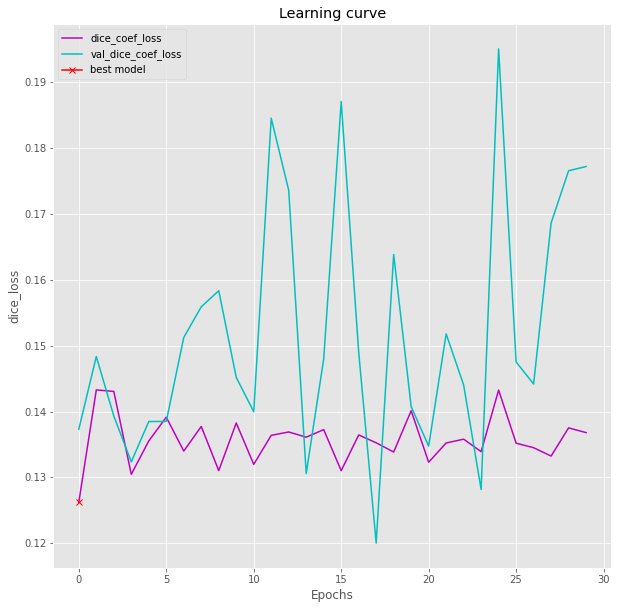

In [29]:
# Dice coef Loss
plt.figure(figsize=(10, 10))
plt.title("Learning curve")
plt.plot(results.history["dice_coef_loss"], label="dice_coef_loss", color="m")
plt.plot(results.history["val_dice_coef_loss"], label="val_dice_coef_loss", color="c")
plt.plot( np.argmin(results.history["dice_coef_loss"]), np.min(results.history["dice_coef_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("dice_loss")
plt.legend()
plt.grid(True)
plt.show()

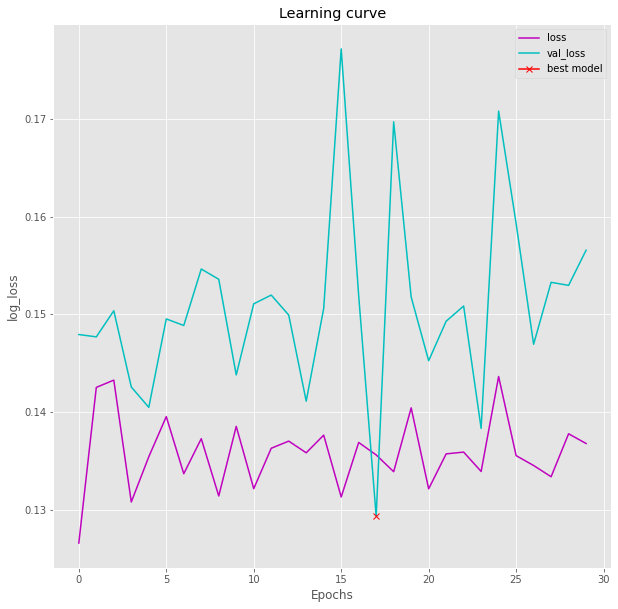

In [30]:
# log loss
plt.figure(figsize=(10, 10))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss", color="m")
plt.plot(results.history["val_loss"], label="val_loss", color="c")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
plt.show()

#### Predictions 

In [31]:
# load the best model
model.load_weights('model-brain-mri_4.h5')

In [32]:
eval_results = model.evaluate(valid_gen, steps=STEP_SIZE_VALID, verbose=1)

11/11 [==============================] - 1s 61ms/step - loss: 0.1448 - accuracy: 0.9970 - dice_coef: 0.8340 - dice_coef_loss: 0.1660


In [33]:
# on test set 

eval_results_test = model.evaluate(test_gen,steps=STEP_SIZE_TEST, verbose=1)

12/12 [==============================] - 2s 122ms/step - loss: 0.1469 - accuracy: 0.9970 - dice_coef: 0.8532 - dice_coef_loss: 0.1468


#### Plot some predictions 

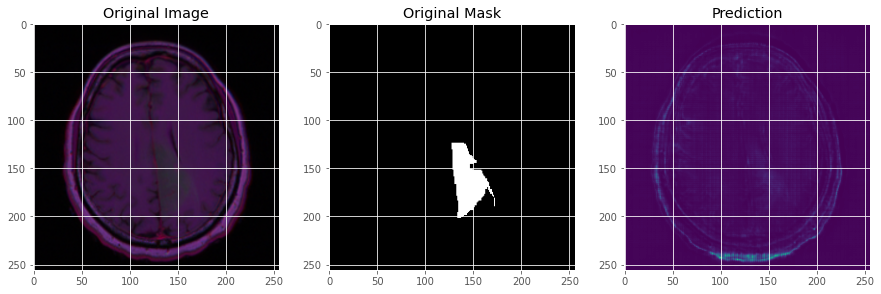

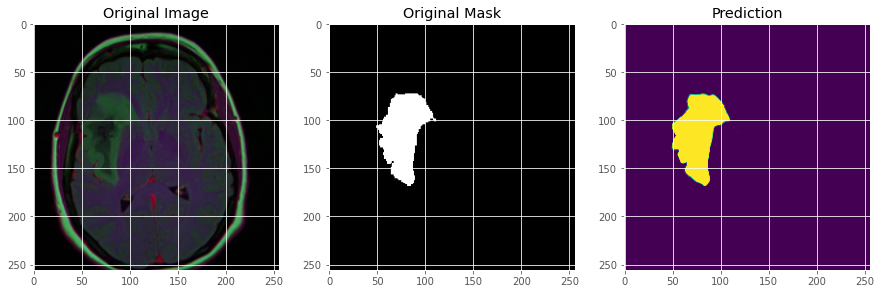

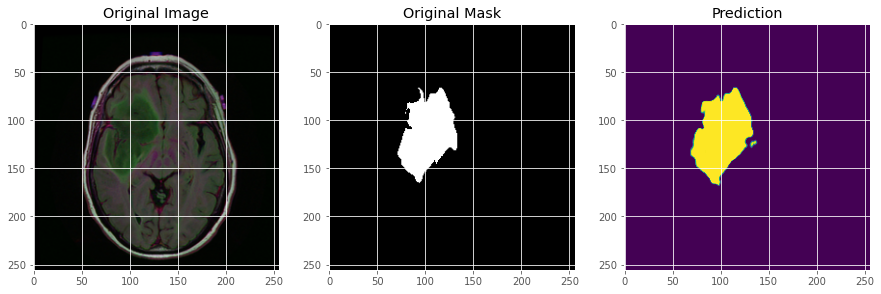

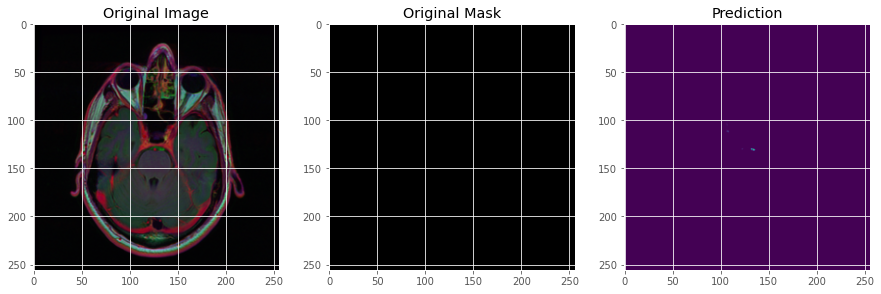

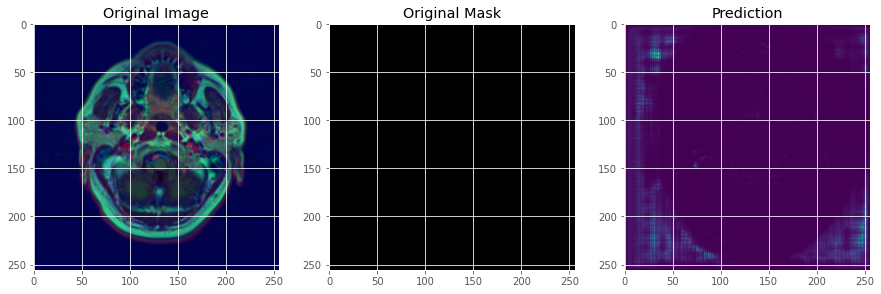

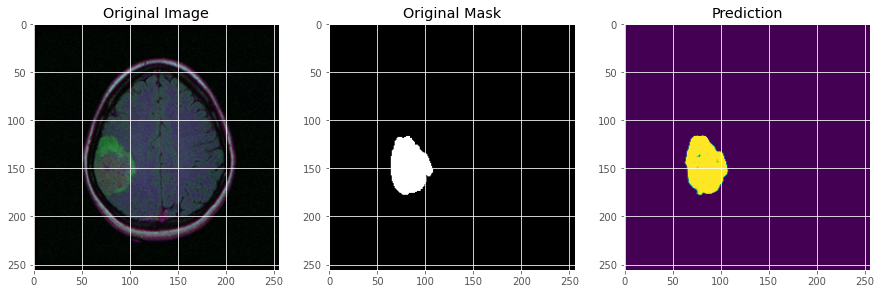

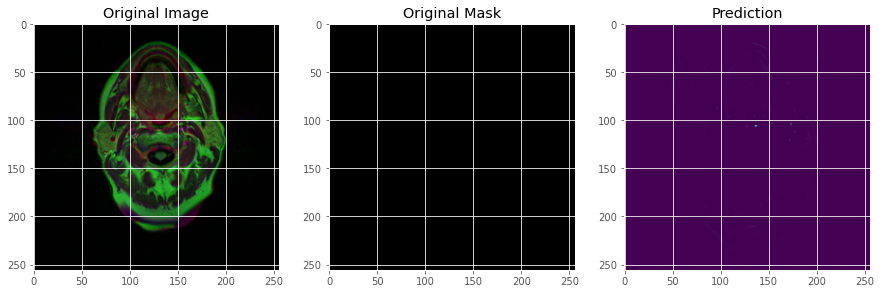

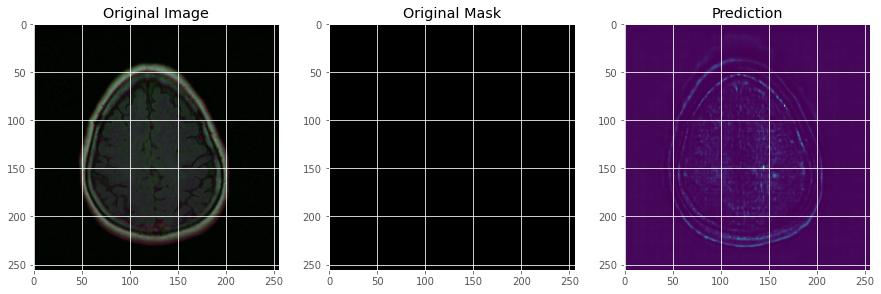

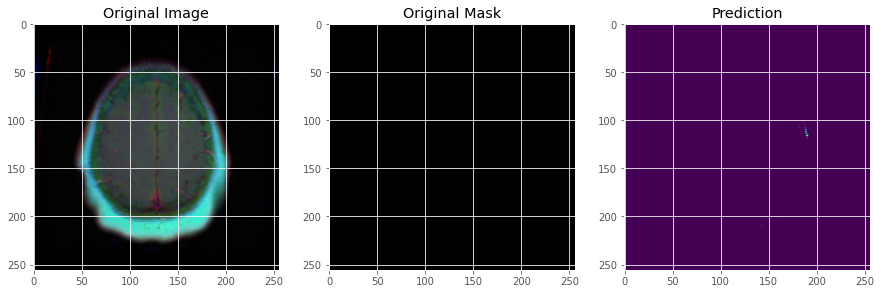

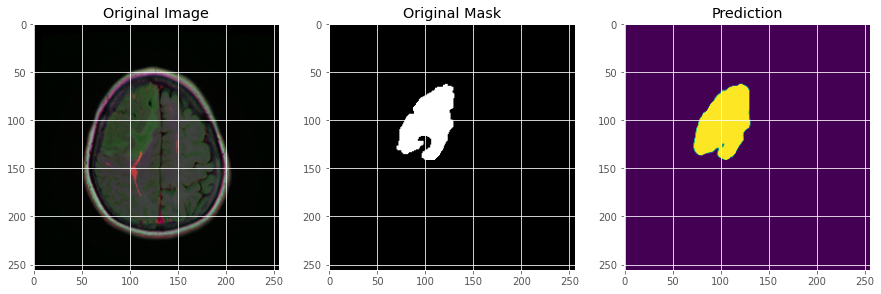

In [35]:
for i in range(10):
    idx = np.random.randint(0, len(imagePath_df))
    
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    img = cv2.resize(image ,(ImgHeight, ImgWidth))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred))
    plt.title('Prediction')